In [6]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import timm
import pathlib
from tqdm import tqdm
from torchvision import transforms
from submodlib.functions import FacilityLocationFunction
from dataload.mnist_load import MNISTDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [3]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])
inv_transform = transforms.Compose([transforms.Normalize([0., 0., 0.], [1/0.229, 1/0.224, 1/0.225]),
                                    transforms.Normalize([-0.485, -0.456, -0.406], [1., 1., 1.])])
# train_dataset = MNISTDataset(subset = True, sub_selection_technique = 'facility_location', transform = transform)

In [3]:
train_dataset = MNISTDataset(subset = True, sub_selection_technique = 'disparity_min', transform = transform)

******************** Selecting Subset ********************
########## Preparing Ground Set ##########
Forming Batches for generating ground set


********** Running Subset Selection **********


In [4]:
train_dataset = MNISTDataset(subset = True, sub_selection_technique = 'disparity_sum', transform = transform)

/home/thomas/optimization_project/opt_proj/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_dataset = MNISTDataset(subset = True, sub_selection_technique = 'log_determinant', transform = transform)

In [7]:
train_dataset = MNISTDataset(subset = True, sub_selection_technique = 'random', transform = transform)

******************** Selecting Subset ********************


In [4]:
model = timm.create_model('resnet50', pretrained=True)
layers = list(model.children())[:-1]
feature_extractor = nn.Sequential(*layers)
for param in feature_extractor.parameters():
    param.requires_grad = False

In [7]:
ground_set = np.zeros((10000, 2048), dtype=np.float32)
for idx, img in tqdm(enumerate(train_dataset), total = 10000):
    if idx == 10000:
        break
    out = feature_extractor(img[None])
    ground_set[idx, :] = out[0].cpu().detach().numpy()

100%|██████████| 10000/10000 [02:09<00:00, 77.27it/s]


In [8]:
fac = FacilityLocationFunction(n = 10000, mode = 'dense', data = ground_set, metric="euclidean")
idxs = fac.maximize(budget = 1000, optimizer='StochasticGreedy', stopIfZeroGain=False, 
                    stopIfNegativeGain=False, verbose=False, show_progress = True)
idxs = [x[0] for x in idxs]

[||||||||||||||||||||]100% [Iteration 1000 of 1000]f 1000]

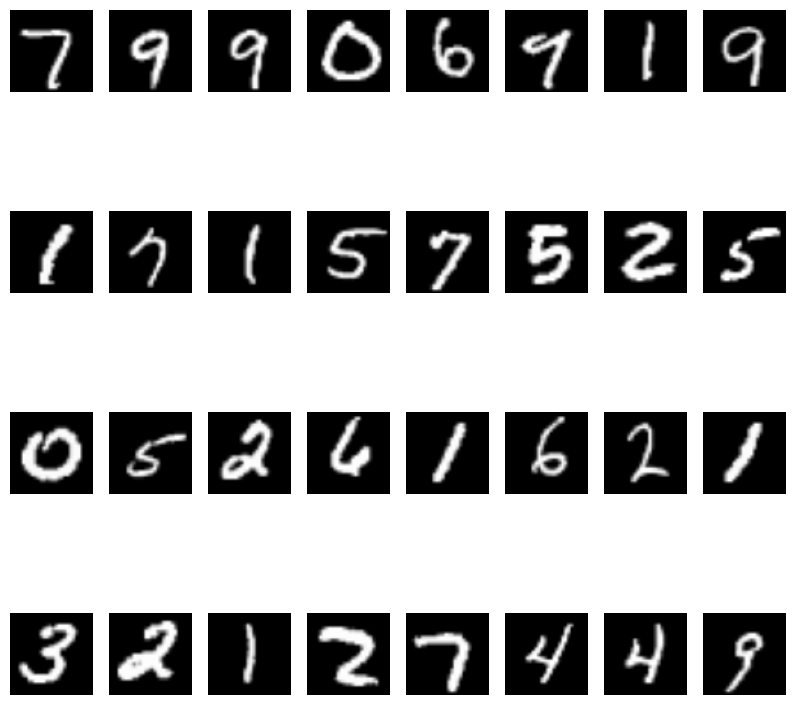

In [52]:
plt.figure(figsize = (10,10))
i = 1
for idx in idxs:
    plt.subplot(4,8, i)
    img = np.transpose(inv_transform(train_dataset[idx]).numpy(), (1,2,0))
    plt.imshow(img)
    plt.axis('off')
    i+=1